# Mean Reversion - (Pairs Trading)

1. Long Pair: Long Stock A and Short Stock B
2. Short Pair: Short Stock A and Long Stock B
3. You want to find a high correlation between stock A and B's price (usually > 0.8) -- in this case lets say 0.9. 
    - If you find a relationship suggesting that the prices move in opposite directions, you can capitalise on this behaviour. 
    - ONCE the assets deviate from their typical correlation, say 0.5, you can long/short the pair since you expect the correlation to converge back to its original form.
- Sort of becomes an art when you try to maximise the spread between the assets.

## Basic Idea 

1. Find 2 assets that move similarly with each other (whether it be a negative or positive correlation)
2. Sell the 'overvalued' stock and buy the 'undervalued' stock
    - A common signal to use to trigger the purchase of a pair trade is to use the price ratio (Stock A/Stock B). 
    - If the ratio changes signiuficantly, then you know it's time to trade. 
    - 'significantly' can be measured with standard deviation.

In [117]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import yfinance as yf
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## Mining the DataSet

In [ ]:
def get_historical_Data(tickers):
    """This function returns a pd dataframe with all of the adjusted closing information"""
    data = pd.DataFrame()
    names = []
    for i in tickers:
        data = pd.concat([data, pd.DataFrame(yf.download(i, start=datetime(2021, 10, 27), end=datetime(2022, 9, 16)).iloc[:,4])], axis = 1)
        names.append(i)
    data.columns = names
    return data

ticks = ["XLP","XLU","XLE","XLV","XLRE","XLF","XLB","XLI","XLK","XLY","XLC","GLD","TLT","SHY","BIL","IEF","IEI","TLH"]

d = get_historical_Data(ticks)
print(d.shape)
# Most Recent Data
d.tail()

In [ ]:
corr_matrix = d.corr()

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(df.shape[1]):
        for j in range(i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(d,50))

In [264]:
# Check out the cointegration value: Null hyp. = no cointegration
STK1 = d['XLRE']
STK2 = d['XLF']
result = ts.coint(STK1, STK2)

Text(0.5, 1.0, 'Historical Adjusted Closing Prices')

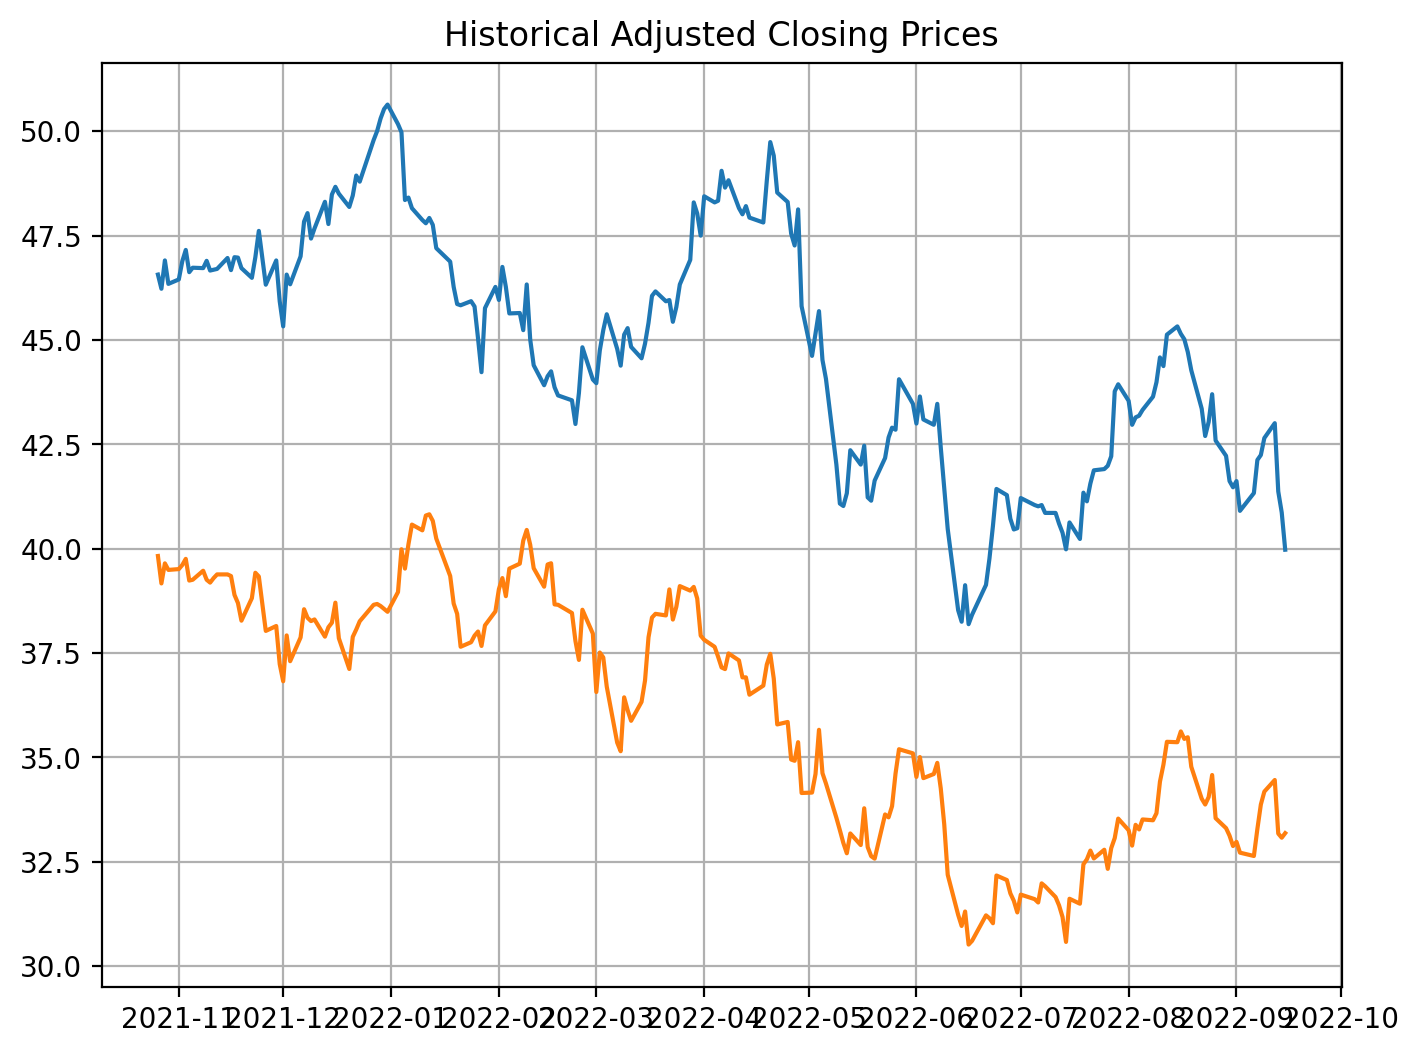

In [265]:
figure(figsize=(8, 6), dpi=200)
plt.plot(STK1)
plt.grid()
plt.plot(STK2)
plt.title('Historical Adjusted Closing Prices')

In [266]:
# Cointegration test: A technique used to find a potential correlation in a time series (long term)
# Determines if the spread between the two assets are constant over time.
# Null Hypothesis: Spread between series are non-stationary.
# Uses the augmented Engle-Granger two-step cointegration test.
cointegration_t_statistic = result[0]
p_val = result[1]
critical_values_test_statistic_at_1_5_10 = result[2]
print('We want the P val < 0.05 (meaning that cointegration exists)')
print('P value for the augmented Engle-Granger two-step cointegration test is', p_val)

We want the P val < 0.05 (meaning that cointegration exists)
P value for the augmented Engle-Granger two-step cointegration test is 0.13069983444568778


In [267]:
# Compute the ADF test for STK1 and STK2
# With all time series, you want to have stationary data otherwise our data will be very hard to predict.
STK1_ADF = adfuller(STK1)
print('P value for the Augmented Dickey-Fuller Test is', STK1_ADF[1])
STK2_ADF = adfuller(STK2)
print('P value for the Augmented Dickey-Fuller Test is', STK2_ADF[1])
Spread_ADF = adfuller(STK1 - STK2)
print('P value for the Augmented Dickey-Fuller Test is', Spread_ADF[1])
Ratio_ADF = adfuller(STK1 / STK2)
print('P value for the Augmented Dickey-Fuller Test is', Ratio_ADF[1])
# Spread looks fine. If you'd want even better results, consider taking the difference (order 1) of STK1 and STK2
# Results: can only claim stationary for the spread (since P value < 0.05). This suggests a constant mean over time.
# Therefore, the two series are cointegrated.

P value for the Augmented Dickey-Fuller Test is 0.6388715581644917
P value for the Augmented Dickey-Fuller Test is 0.5354144878160731
P value for the Augmented Dickey-Fuller Test is 0.027441401152148808
P value for the Augmented Dickey-Fuller Test is 0.04407183765898667


Text(0.5, 1.0, 'Price Ratio')

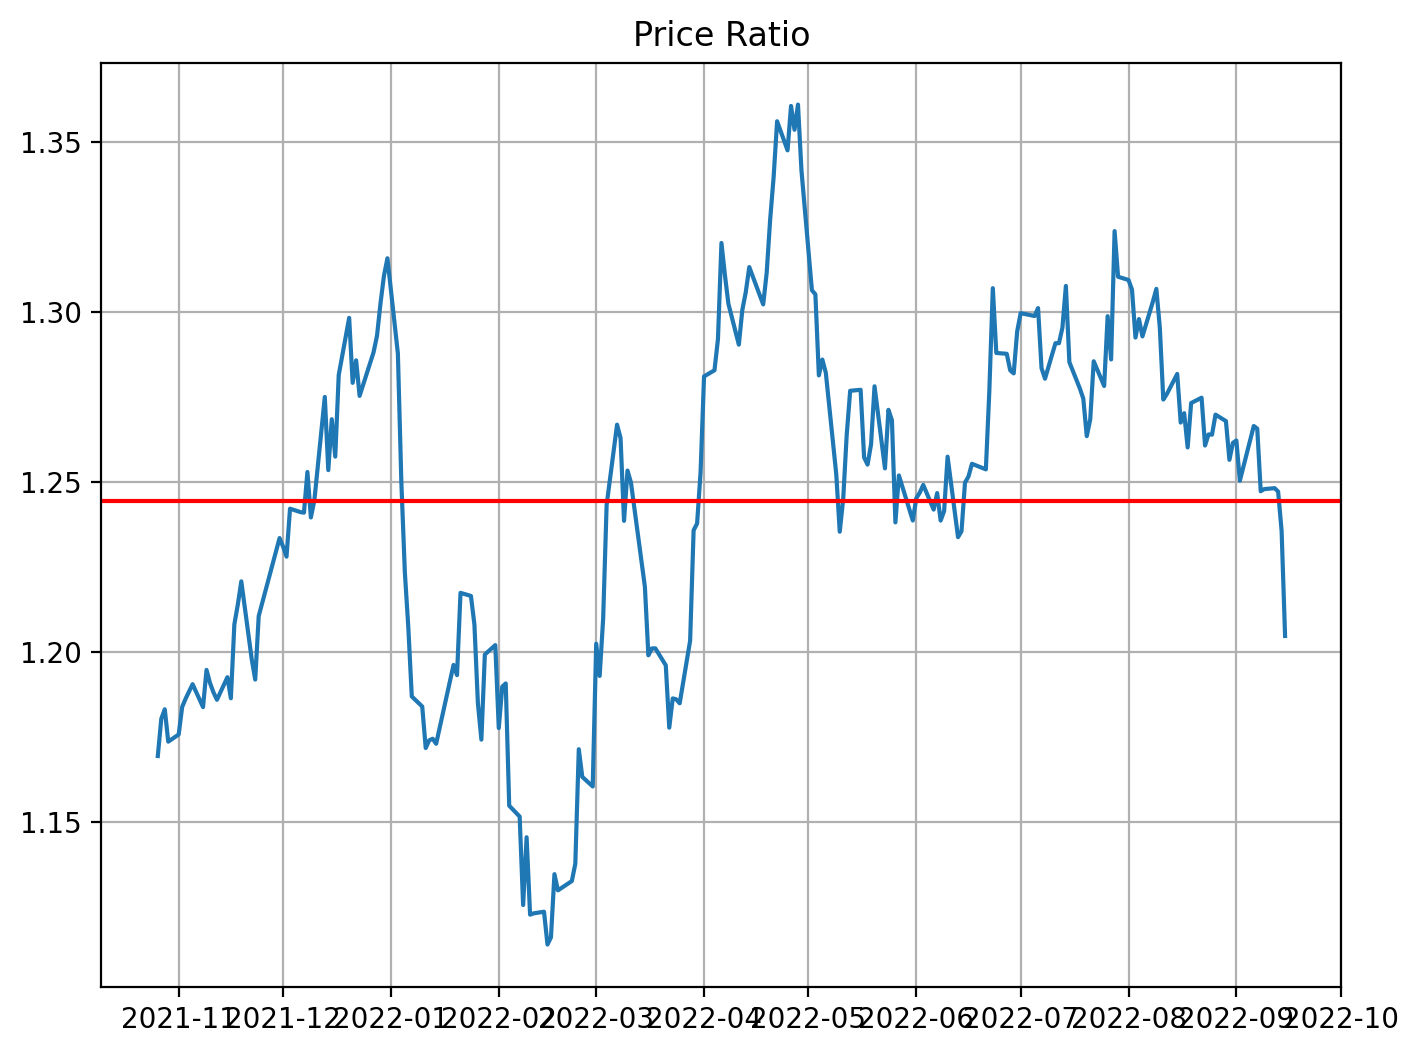

In [268]:
# Also, we can take a look at the price ratios between the two time series.
figure(figsize=(8, 6), dpi=200)
ratio = STK1 / STK2
plt.plot(ratio, label = 'Price Ratio')
plt.axhline(ratio.mean(), color='red')
plt.grid()
plt.title("Price Ratio")

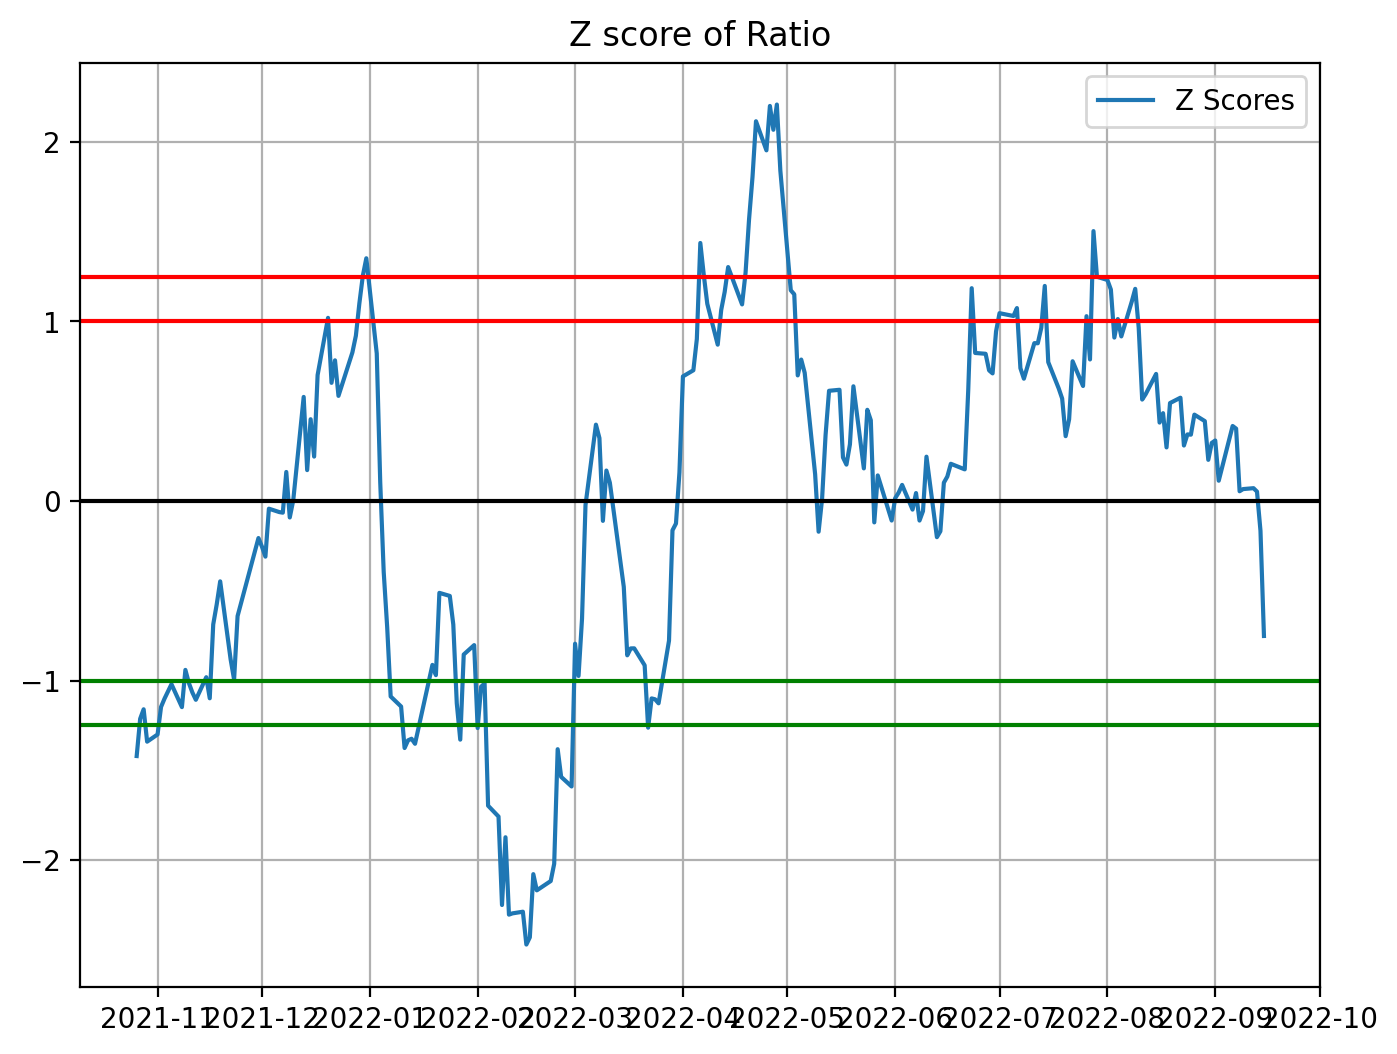

In [269]:
# NOTE, here you can either use the spread OR the Price ratio approach. Anyways, let's standardize the ratio so we can have a 
# upper and lower bound to help evaluate our trends.. Let's stick with the ratio data.
figure(figsize=(8, 6), dpi=200)
# Calculate the Zscores of each row.
df_zscore = (ratio - ratio.mean())/ratio.std()
plt.plot(df_zscore, label = "Z Scores")
plt.axhline(df_zscore.mean(), color = 'black')
plt.grid()
plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
plt.axhline(1.25, color='red') # 95% of our data will lie between these bounds.
plt.axhline(-1.0, color='green') # 68% of our data will lie between these bounds.
plt.axhline(-1.25, color='green') # 95% of our data will lie between these bounds.
plt.legend(loc = 'best')
plt.title('Z score of Ratio')
plt.show()
# For the most part, the range that exists outside of these 'bands' must come converge back to the mean. Thus, you can 
# determine when you can go long or short the pair.

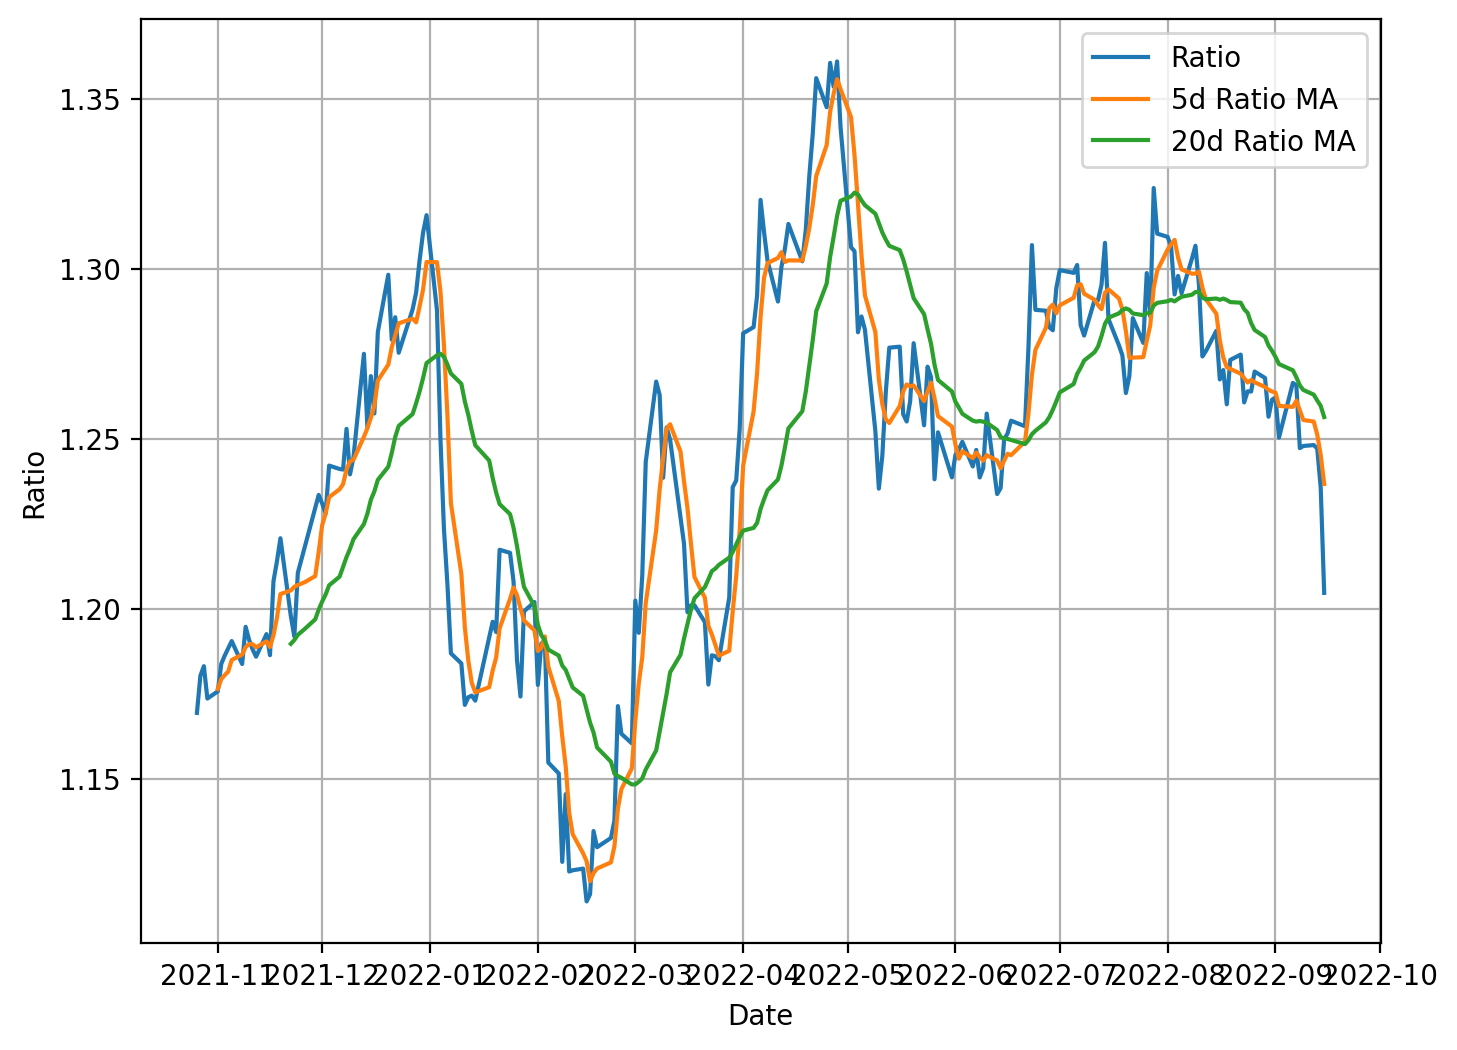

In [270]:
figure(figsize=(8, 6), dpi=200)
ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
ratios_mavg20 = ratio.rolling(window=20, center=False).mean()
std_20 = ratio.rolling(window=20, center=False).std()
zscore_20_5 = (ratios_mavg5 - ratios_mavg20)/std_20
plt.plot(ratio.index, ratio.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.grid()
plt.plot(ratios_mavg20.index, ratios_mavg20.values)
plt.legend(['Ratio', '5d Ratio MA', '20d Ratio MA'])
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.show()

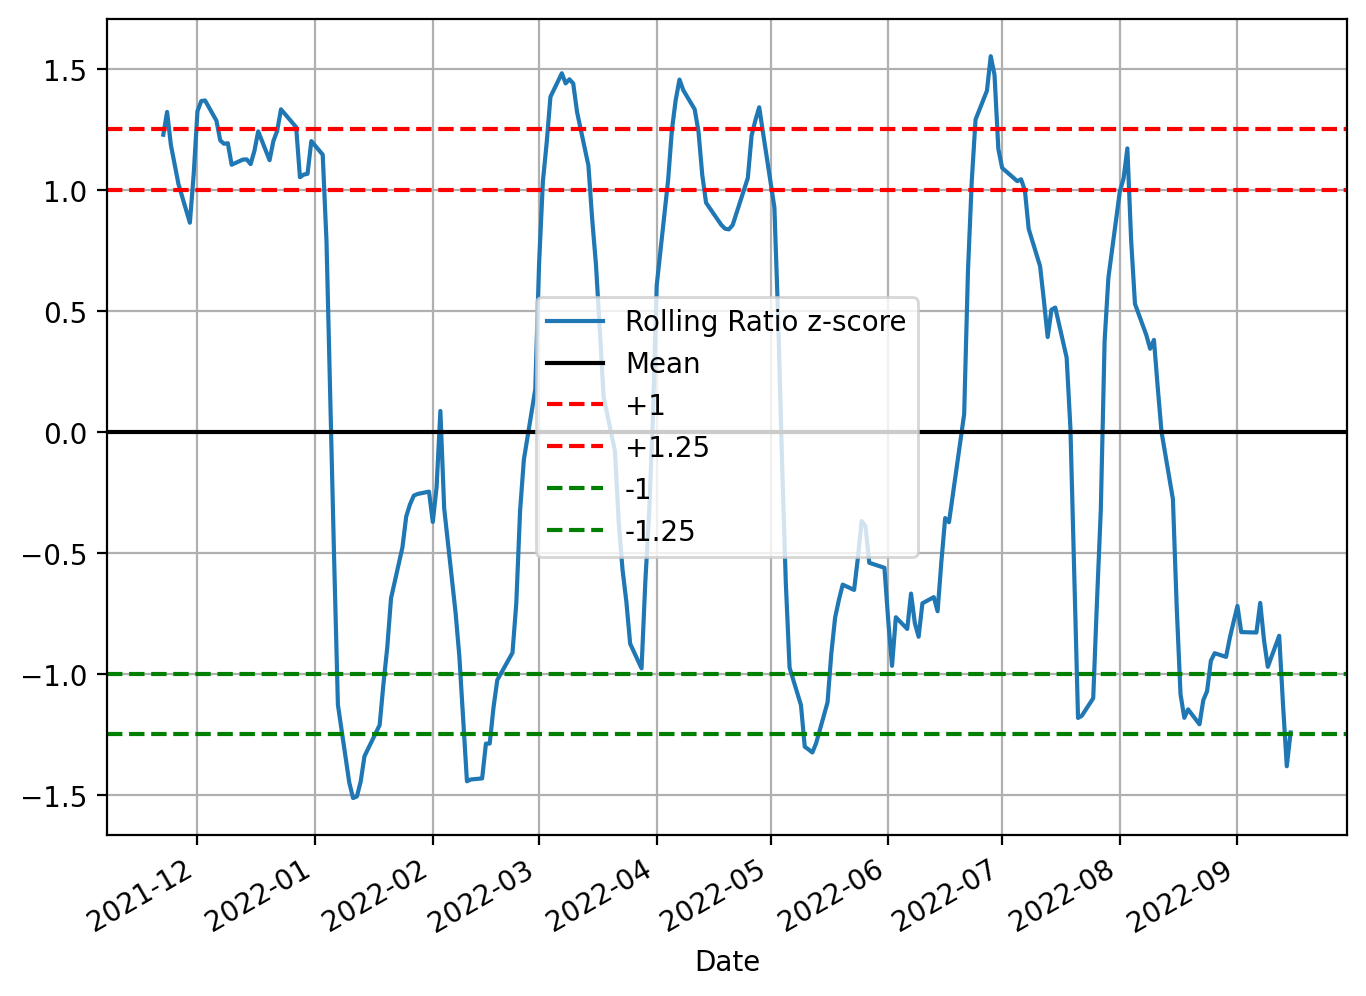

In [271]:
figure(figsize=(8, 6), dpi=200)
zscore_20_5.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(1.25, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.grid()
plt.axhline(-1.25, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1','+1.25','-1','-1.25'])
plt.show()

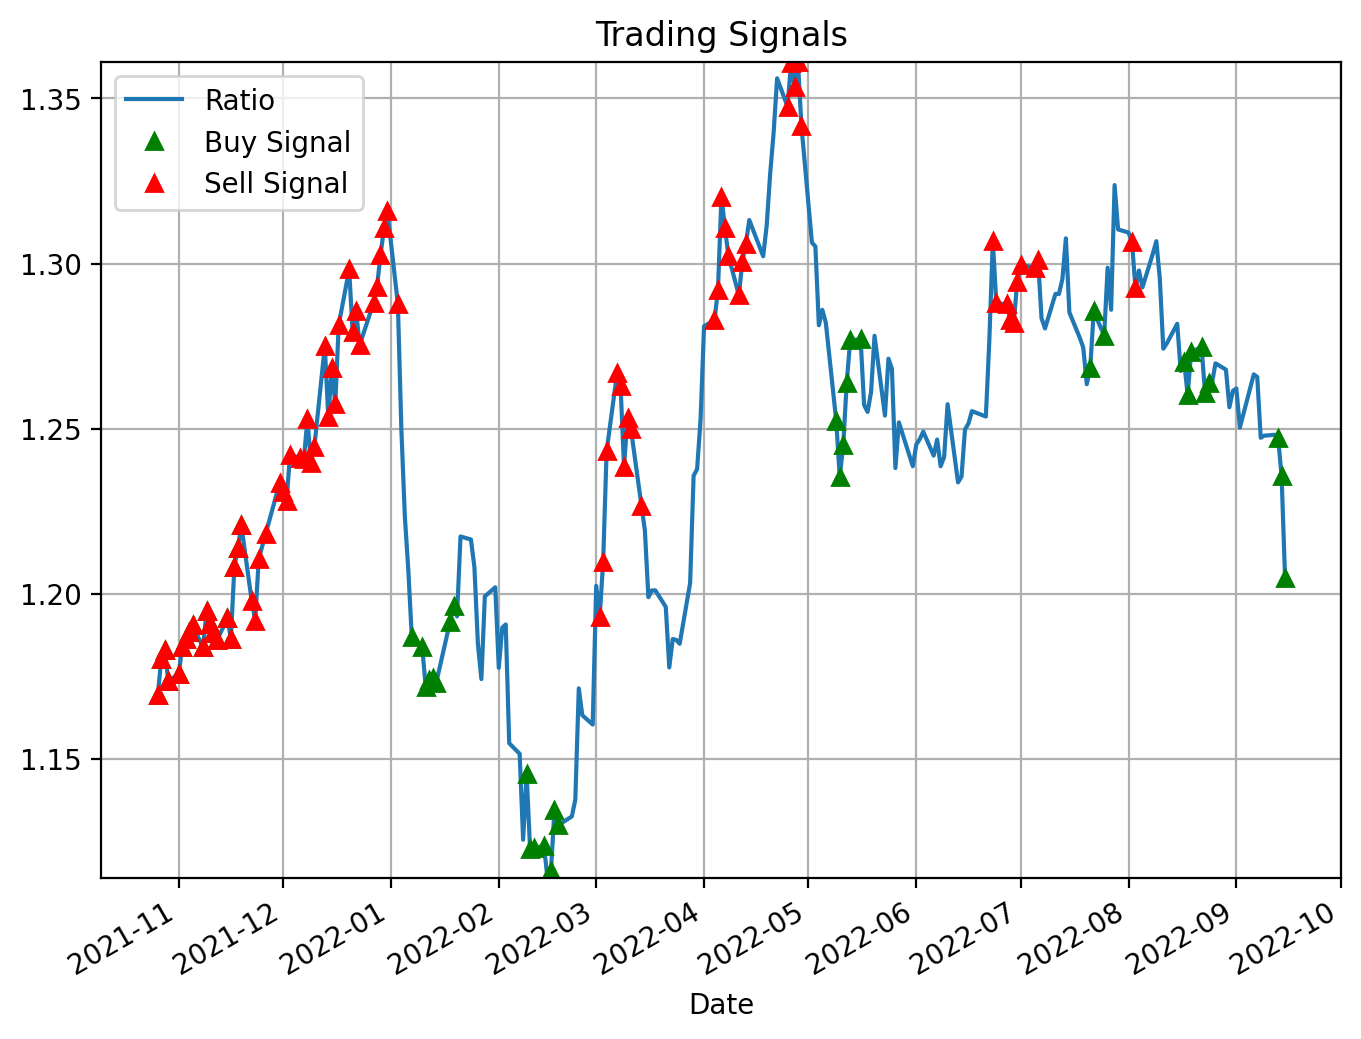

In [272]:
figure(figsize=(8, 6), dpi=200)
ratio.plot()
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_20_5>-1] = 0
sell[zscore_20_5<1] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.grid()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Trading Signals')
plt.show()